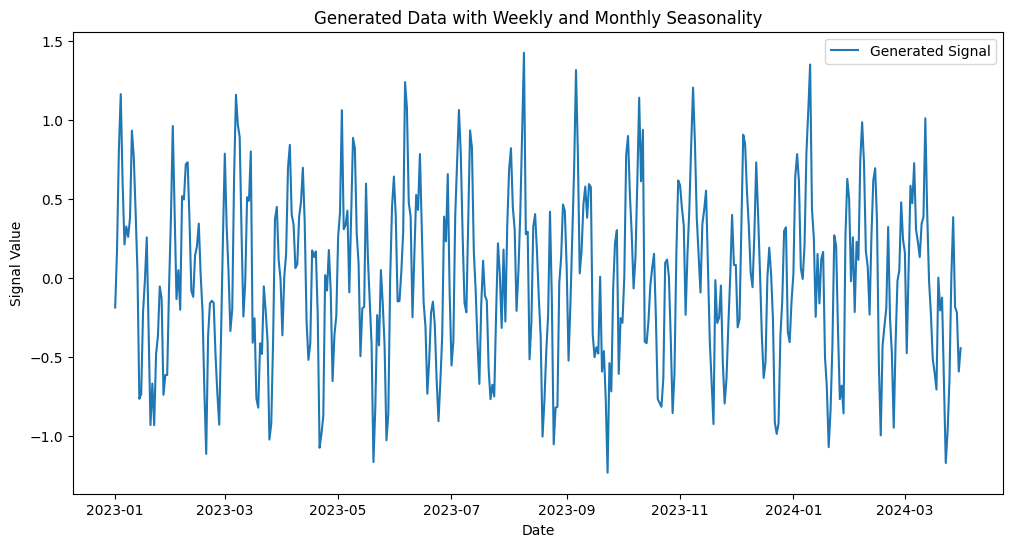

Epoch 1/50
8/8 [==============================] - 4s 173ms/step - loss: 0.2476 - val_loss: 0.1925
Epoch 2/50
8/8 [==============================] - 0s 53ms/step - loss: 0.1541 - val_loss: 0.0958
Epoch 3/50
8/8 [==============================] - 0s 53ms/step - loss: 0.0650 - val_loss: 0.0441
Epoch 4/50
8/8 [==============================] - 0s 52ms/step - loss: 0.0450 - val_loss: 0.0425
Epoch 5/50
8/8 [==============================] - 0s 58ms/step - loss: 0.0431 - val_loss: 0.0355
Epoch 6/50
8/8 [==============================] - 1s 67ms/step - loss: 0.0407 - val_loss: 0.0350
Epoch 7/50
8/8 [==============================] - 0s 45ms/step - loss: 0.0383 - val_loss: 0.0338
Epoch 8/50
8/8 [==============================] - 0s 58ms/step - loss: 0.0375 - val_loss: 0.0323
Epoch 9/50
8/8 [==============================] - 0s 55ms/step - loss: 0.0363 - val_loss: 0.0313
Epoch 10/50
8/8 [==============================] - 0s 38ms/step - loss: 0.0351 - val_loss: 0.0303
Epoch 11/50
8/8 [===========

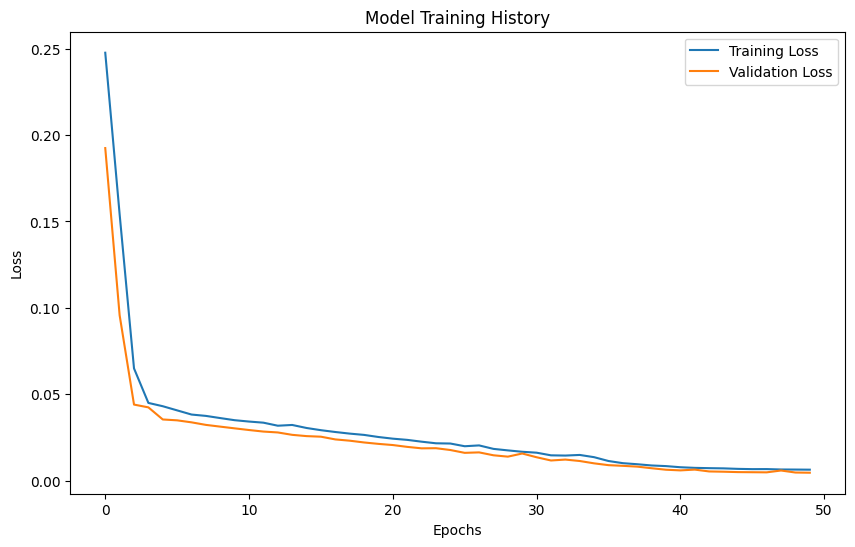

3/3 [==============================] - 0s 11ms/step


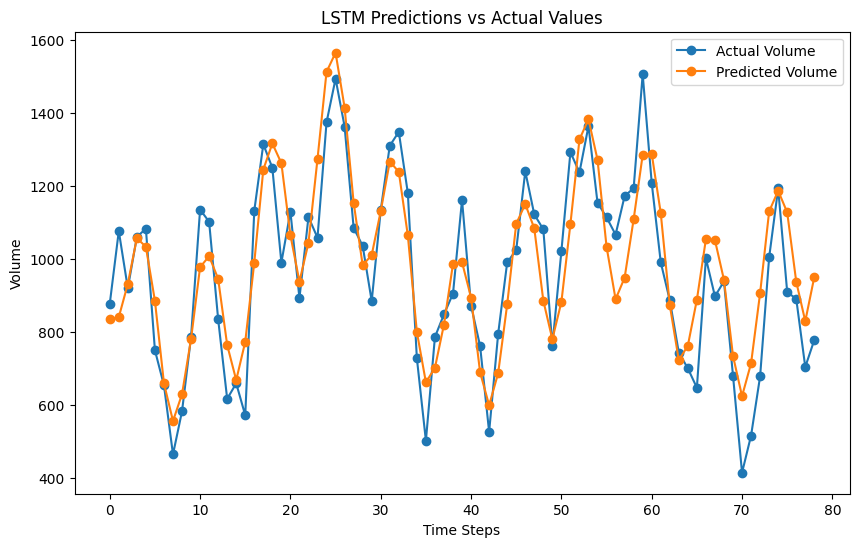

Mean Absolute Error (MAE): 100.93351602012854


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Generating sample data
np.random.seed(42)

date_range = pd.date_range(start='2023-01-01', end='2024-03-31', freq='D')
df = pd.DataFrame(index=date_range)

weekly_seasonality = np.sin(2 * np.pi * df.index.weekday / 7)
df['weekly_seasonality'] = weekly_seasonality

monthly_seasonality = np.sin(2 * np.pi * df.index.day / 30)
df['monthly_seasonality'] = monthly_seasonality

df['combined_seasonality'] = 0.5 * weekly_seasonality + 0.5 * monthly_seasonality

noise = np.random.normal(loc=0, scale=0.2, size=len(df))
df['noise'] = noise

df['signal'] = df['combined_seasonality'] + df['noise']

plt.figure(figsize=(12, 6))
plt.plot(df['signal'], label='Generated Signal')
plt.title('Generated Data with Weekly and Monthly Seasonality')
plt.xlabel('Date')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

df['isMon'] = (df.index.dayofweek == 0).astype(int)
df['isTue'] = (df.index.dayofweek == 1).astype(int)
df['isWed'] = (df.index.dayofweek == 2).astype(int)
df['isThu'] = (df.index.dayofweek == 3).astype(int)
df['isFri'] = (df.index.dayofweek == 4).astype(int)
df['isSat'] = (df.index.dayofweek == 5).astype(int)
df['isSun'] = (df.index.dayofweek == 6).astype(int)
df['Volume'] = 1000 + (500 * df['signal'])

# Removed unnecessary column drops
df = df.drop(['weekly_seasonality', 'monthly_seasonality', 'weekly_seasonality', 'combined_seasonality', 'signal', 'noise'], axis=1)

def prepare_data(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix, :].values  # Removed .flatten()
        seq_y = data.iloc[end_ix:out_end_ix, -1].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

n_steps_in = 60
n_steps_out = 3

X, y = prepare_data(pd.DataFrame(scaled_data), n_steps_in, n_steps_out)

split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train = X_train.reshape(X_train.shape[0], n_steps_in, -1)
X_test = X_test.reshape(X_test.shape[0], n_steps_in, -1)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, X_train.shape[2])))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(patience=5)])

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Invert scaling for actual values
y_test_inv = y_test * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

# Invert scaling for predicted values
y_pred_inv = y_pred * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:, -1], label='Actual Volume', marker='o')
plt.plot(y_pred_inv[:, -1], label='Predicted Volume', marker='o')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inv[:, -1], y_pred_inv[:, -1])
print(f'Mean Absolute Error (MAE): {mae}')

1/1 [==============================] - 0s 40ms/step


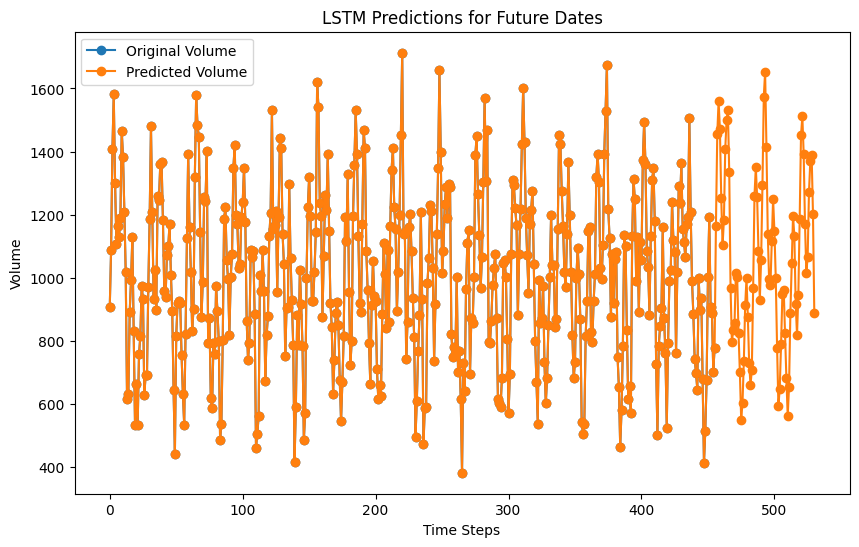

In [32]:
# ... (your existing code)

# Specify the date range for prediction
prediction_start_date = '2024-04-01'
prediction_end_date = '2024-06-12'
prediction_date_range = pd.date_range(start=prediction_start_date, end=prediction_end_date, freq='D')

# Generate a DataFrame for the prediction date range with features (isMon, isTue, ...)
prediction_df = pd.DataFrame(index=prediction_date_range)
prediction_df['isMon'] = (prediction_df.index.dayofweek == 0).astype(int)
prediction_df['isTue'] = (prediction_df.index.dayofweek == 1).astype(int)
prediction_df['isWed'] = (prediction_df.index.dayofweek == 2).astype(int)
prediction_df['isThu'] = (prediction_df.index.dayofweek == 3).astype(int)
prediction_df['isFri'] = (prediction_df.index.dayofweek == 4).astype(int)
prediction_df['isSat'] = (prediction_df.index.dayofweek == 5).astype(int)
prediction_df['isSun'] = (prediction_df.index.dayofweek == 6).astype(int)
prediction_df['Volume'] = np.nan

old_new_combo_df = pd.concat([df, prediction_df])
old_new_combo_df['Volume_backup'] = old_new_combo_df['Volume']

old_new_combo_df = old_new_combo_df.reset_index()

for i in range(len(old_new_combo_df)):
    if np.isnan(old_new_combo_df.loc[i, 'Volume']):
        # Prepare data for prediction
        scaled_data_temp = scaler.transform(old_new_combo_df.iloc[i - n_steps_in:i, :].drop(['Volume_backup', 'index'], axis=1))
        seq_x = scaled_data_temp.reshape(1, n_steps_in, -1)

        # Make predictions using the trained model
        predicted_volume = model.predict(seq_x)

        # Invert scaling for predicted values
        predicted_volume_inv = predicted_volume * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

        # Update the 'Volume' column in old_new_combo_df with the predicted values
        for j in range(n_steps_out):
            old_new_combo_df.loc[i + j, 'Volume'] = predicted_volume_inv[0, j]

# Plot the original and predicted values
plt.figure(figsize=(10, 6))
plt.plot(old_new_combo_df['Volume_backup'], label='Original Volume', marker='o')
plt.plot(old_new_combo_df['Volume'], label='Predicted Volume', marker='o')
plt.title('LSTM Predictions for Future Dates')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()


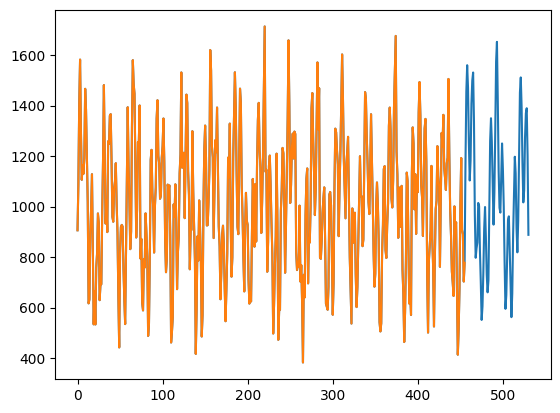

In [33]:
plt.plot(old_new_combo_df.Volume)
plt.plot(old_new_combo_df.Volume_backup)